# 4 Training and Modeling Data<a id='4_Training_and_Modeling_Data'></a>

## Contents <a id ="Content" > </a>

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Train Test Split](#Train_Test_Split) 
* [Training and Modeling](#Training_and_Modeling)
    * [Model Selection](#Model_Selection)
    * [Evaluation Metrics](#Evaluation-Metrics)
        * [Training and Modeling](#Train_and_Model)
        * [Hyperparameter Tuning and Model Training](#Hyperparameter_Tuning_Training)
            * [Logistic Regression](#Logistic_Regression)
            * [Random Forest Classification](#Random_Forest)
            * [KNeighbours Classification](#KNN)
            * [XGBoost Classification](#XGB)
* [Evaluation](#Evaluation)
    * [Logistic Regression](#LogiEval)
        * [Feature Importance](#LogiregFImp)
    * [Random Forest Classification](#RFEVAL)
        * [Feature Importance](#RFFImp)
    * [KNeighbours Classification](#KNNEval)
        * [Feature Importance](#KNNFImp)
    * [XGBoost Classification](#XGBEval)
        * [Feature Importance](#FeaImp)
* [ROC Curve](#ROCCurve)
* [Additional Models](#AdditionalModels)
* [Summary](#Summary)
* [Recommendations](#Recom)

## Introduction <a id = 'Introduction'></a>

Four different supervised machine learning models are used to predict credit card. 
* Logistic Regression classification
* Random Forest classifier
* KNeighbours classification
* GBoost classifier

Models are optimized either with GridsearchCV or Randomized Search technique.
Models are evaluated  using the confusion matrix and ROC_AUC Score.

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neural_network import MLPclassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score, roc_curve, log_loss
from sklearn.metrics import f1_score, auc, precision_recall_curve

# remove warning
import warnings
warnings.filterwarnings("ignore")


In [2]:
ccattr_data = pd.read_csv("../data/3.ccattr_data_EDA_final.csv")

In [3]:
ccattr_data.dtypes

CLIENTNUM                          int64
Attrition_Numeric                  int64
Customer_Age_zScore              float64
Credit_Limit_log                 float64
Total_Revolving_Bal_divMedian    float64
Total_Trans_Amt_log              float64
Avg_Utilization_Ratio            float64
Gender                            object
Dependent_count                    int64
Education_Level_sorted            object
Marital_Status_sorted             object
Income_Category_sorted            object
Card_Category_sorted              object
Months_on_book_zScore            float64
Total_Relationship_Count           int64
Months_Inactive_12_mon             int64
Contacts_Count_12_mon              int64
naive_cls1                       float64
naive_cls2                       float64
dtype: object

In [4]:
ccattr_data.shape

(10127, 19)

In [5]:
ccattr_data.head().T

,0,1,2,3,4
CLIENTNUM,714648933,717628608,711777633,716645883,708217758
Attrition_Numeric,0,0,0,0,0
Customer_Age_zScore,1.082034,-1.163358,-0.664382,0.084082,2.079986
Credit_Limit_log,8.488999,7.853993,8.662851,9.537267,9.549309
Total_Revolving_Bal_divMedian,0.880094,1.285266,0.0,0.0,1.615204
Total_Trans_Amt_log,7.349874,7.850883,8.33639,8.365672,7.381502
Avg_Utilization_Ratio,0.231,0.637,0.0,0.0,0.147
Gender,F,M,M,M,M
Dependent_count,3,3,3,2,2
Education_Level_sorted,Graduate,Graduate,Graduate,Graduate,Graduate


In [6]:
ccattr_data.dtypes

CLIENTNUM                          int64
Attrition_Numeric                  int64
Customer_Age_zScore              float64
Credit_Limit_log                 float64
Total_Revolving_Bal_divMedian    float64
Total_Trans_Amt_log              float64
Avg_Utilization_Ratio            float64
Gender                            object
Dependent_count                    int64
Education_Level_sorted            object
Marital_Status_sorted             object
Income_Category_sorted            object
Card_Category_sorted              object
Months_on_book_zScore            float64
Total_Relationship_Count           int64
Months_Inactive_12_mon             int64
Contacts_Count_12_mon              int64
naive_cls1                       float64
naive_cls2                       float64
dtype: object

In [7]:
# Label Encode categorical variables 

marital_status = {'Married':1,'Single':2, 'Divorced':3}
ccattr_data['Marital_Status_sorted']=ccattr_data['Marital_Status_sorted'].map(marital_status)


education = {'Uneducated':1,'High School':2, 'Graduate':3, 'College':4, 'Post-Graduate':5, 'Doctorate':6}
ccattr_data['Education_Level_sorted']=ccattr_data['Education_Level_sorted'].map(education)

income = {'0K - 40K':1,'40k − 60K':2, '80K - 120K':3, '60K - 80K':4, '120K +':5}
ccattr_data['Income_Category_sorted']=ccattr_data['Income_Category_sorted'].map(income)

In [8]:
#Checking that no column has missing values 
ccattr_data.isnull().sum()

CLIENTNUM                        0
Attrition_Numeric                0
Customer_Age_zScore              0
Credit_Limit_log                 0
Total_Revolving_Bal_divMedian    0
Total_Trans_Amt_log              0
Avg_Utilization_Ratio            0
Gender                           0
Dependent_count                  0
Education_Level_sorted           0
Marital_Status_sorted            0
Income_Category_sorted           0
Card_Category_sorted             0
Months_on_book_zScore            0
Total_Relationship_Count         0
Months_Inactive_12_mon           0
Contacts_Count_12_mon            0
naive_cls1                       0
naive_cls2                       0
dtype: int64

In [9]:
## Converting the data type of categorical features to 'category'

cat_cols = ['Attrition_Numeric','Gender', 'Education_Level_sorted', 'Marital_Status_sorted', 'Income_Category_sorted', 'Card_Category_sorted','Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon']

ccattr_data[cat_cols] = ccattr_data[cat_cols].astype('category')
ccattr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   CLIENTNUM                      10127 non-null  int64   
 1   Attrition_Numeric              10127 non-null  category
 2   Customer_Age_zScore            10127 non-null  float64 
 3   Credit_Limit_log               10127 non-null  float64 
 4   Total_Revolving_Bal_divMedian  10127 non-null  float64 
 5   Total_Trans_Amt_log            10127 non-null  float64 
 6   Avg_Utilization_Ratio          10127 non-null  float64 
 7   Gender                         10127 non-null  category
 8   Dependent_count                10127 non-null  category
 9   Education_Level_sorted         10127 non-null  category
 10  Marital_Status_sorted          10127 non-null  category
 11  Income_Category_sorted         10127 non-null  category
 12  Card_Category_sorted           1

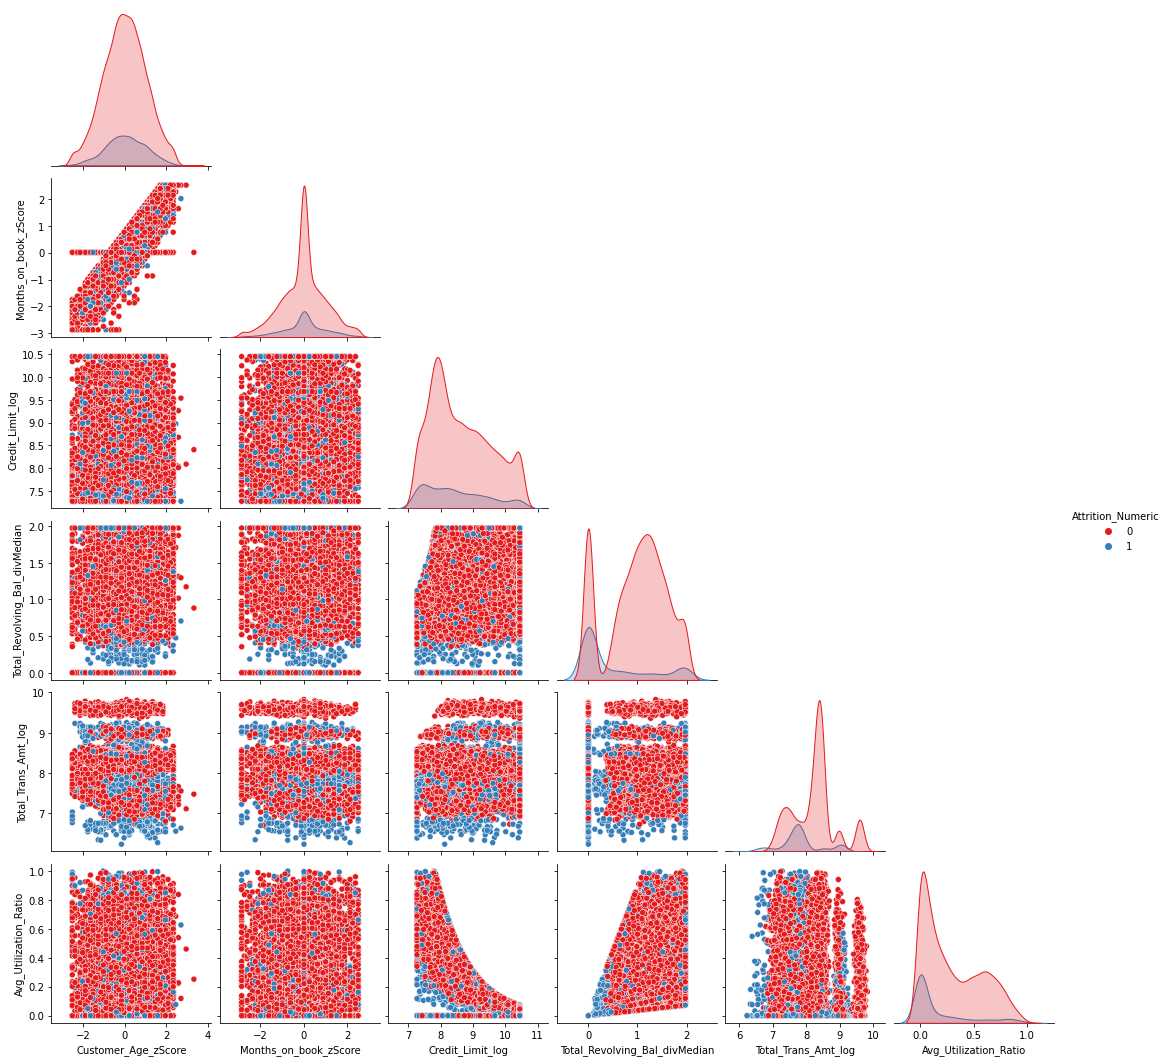

In [10]:
#Corralation

list_cols = ['Attrition_Numeric','Customer_Age_zScore','Dependent_count', 'Months_on_book_zScore',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit_log', 'Total_Revolving_Bal_divMedian',
              'Total_Trans_Amt_log','Avg_Utilization_Ratio']
sns.set_palette(sns.color_palette("Set1", 8))
sns.pairplot(ccattr_data[list_cols], hue="Attrition_Numeric",corner=True)
plt.show()

Looking at the plot it is evident that classifiers are the best models than the linear regressor.

## Train Test Split <a id=Train_Test_Split></a>

In [11]:
# Creating X and y
X = ccattr_data.drop(['Attrition_Numeric','CLIENTNUM','naive_cls1','naive_cls2'],axis=1)
y = ccattr_data['Attrition_Numeric']

In [12]:
# Splitting the data into train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1,stratify=y)
X_train.shape, X_test.shape

((7088, 15), (3039, 15))

In [13]:
y_train.shape, y_test.shape

((7088,), (3039,))

In [14]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
print(X_train.shape, X_test.shape)

(7088, 43) (3039, 43)


In [15]:
X_train.T

,4410,4930,1335,6267,2413,3267,6000,9667,5729,1705,...,6132,261,670,9797,9616,3176,9425,9816,1890,4995
Customer_Age_zScore,-0.539638,-0.539638,-0.040662,-1.288101,1.581010,0.832546,0.208826,0.707802,-0.165406,-0.165406,...,-0.414894,-1.288101,0.208826,-1.787077,-0.664382,-1.038614,-1.911821,-0.913870,0.084082,0.458314
Credit_Limit_log,10.312845,8.285009,7.555905,9.568294,8.352554,9.941891,8.380457,10.449178,7.271217,8.791182,...,7.574045,7.839919,7.776535,10.425579,9.866875,8.304742,8.457868,10.449178,9.563880,8.006034
Total_Revolving_Bal_divMedian,1.668495,0.954545,0.918495,0.547806,0.000000,0.985110,0.631661,1.268025,0.846395,0.000000,...,0.000000,1.098746,1.250784,1.126176,1.414577,1.972571,0.748433,0.623824,1.630878,1.423981
Total_Trans_Amt_log,8.978408,8.429454,8.484877,8.465057,7.494430,8.247744,8.415825,9.359019,8.395026,7.289611,...,7.658700,7.776535,8.054840,9.607773,9.643615,7.863267,7.850883,8.951699,7.365813,8.540714
Avg_Utilization_Ratio,0.071000,0.307000,0.613000,0.049000,0.000000,0.060000,0.185000,0.047000,0.751000,0.000000,...,0.000000,0.552000,0.669000,0.043000,0.094000,0.623000,0.203000,0.023000,0.146000,0.606000
Months_on_book_zScore,0.008965,-0.617129,0.134183,0.008965,2.137684,1.386371,0.134183,1.010715,-0.116254,0.008965,...,0.259402,-0.992786,0.760277,0.008965,0.008965,-0.742348,-1.994536,-2.119755,0.008965,0.008965
Gender_M,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
Dependent_count_1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dependent_count_2,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
Dependent_count_3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [16]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

Customer_Age_zScore              float64
Credit_Limit_log                 float64
Total_Revolving_Bal_divMedian    float64
Total_Trans_Amt_log              float64
Avg_Utilization_Ratio            float64
Months_on_book_zScore            float64
Gender_M                           uint8
Dependent_count_1                  uint8
Dependent_count_2                  uint8
Dependent_count_3                  uint8
Dependent_count_4                  uint8
Dependent_count_5                  uint8
Education_Level_sorted_2           uint8
Education_Level_sorted_3           uint8
Education_Level_sorted_4           uint8
Education_Level_sorted_5           uint8
Education_Level_sorted_6           uint8
Marital_Status_sorted_2            uint8
Marital_Status_sorted_3            uint8
Income_Category_sorted_2           uint8
Income_Category_sorted_3           uint8
Income_Category_sorted_4           uint8
Income_Category_sorted_5           uint8
Card_Category_sorted_Gold          uint8
Card_Category_so

Since dataset is imbalanced trying oversampling using SMOTE to get better performance

In [17]:
print(f"Before SMOTE,attrited customer: {sum(y_train==1)}")
print(f"Before SMOTE,existing customer: {sum(y_train==0)} \n")

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train.ravel())

print(f"After SMOTE,attrited customer: {sum(y_train_over==1)}")
print(f"After SMOTE,existing customer: {sum(y_train_over==0)} \n")

print(f'After SMOTE, the shape of train_X: {X_train_over.shape}')
print(f'After SMOTE, the shape of train_y: {y_train_over.shape} \n')

Before SMOTE,attrited customer: 1139
Before SMOTE,existing customer: 5949 

After SMOTE,attrited customer: 5949
After SMOTE,existing customer: 5949 

After SMOTE, the shape of train_X: (11898, 43)
After SMOTE, the shape of train_y: (11898,) 



## Training and Modeling <a id=Training_and_Modeling ></a>

### Model Selection <a id=Model_Selection ></a>

Four competing supervised classfication models/algorithms are considered, namely, 
* Logistic Regression classification
* Random Forest classifier
* KNeighbours classification
* GBoost classifier 

### Evaluation Metrics <a id=Evaluation-Metrics ></a>

Since classes in the data are unbalanced, we need to examine the confusion matrix. Recall and precision can be calculated from the confusion matrix, and allow us to assess the models.

In this project, we aim to predict potential churn customers, and we realise that the client cost of mistakenly classifying non-churn customer as churn may be high in practice because banks would not want to lose valuable customers, and the banks would like to identify churners at their best efforts as well. Thus, it would be useful to consider Precision and Recall simultaneously. Evaluation based on Precision and Recall does not take into account the majority class (True negative) and the estimates may be biased towards the minority class. To complement this Receiver Operating Characteristic curve (ROC) is used. ROC is a plot of True Positive Rate (TPR) against False Positive Rate (FPR).

To consider TPR and FPR simultanesouly, we can make use of the area under the curve (AUC) of ROC.

### Training and Modeling <a id=Train_and_Model>

In [18]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,plot_confusion_matrix #to plot confusion matric
def make_confusion_matrix(y_actual,y_predict,title):
    fig, ax = plt.subplots(1, 1)
    
    Con_Mtx = confusion_matrix(y_actual, y_predict, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=Con_Mtx,
                               display_labels=["No","Yes"])
    disp.plot(cmap='Blues',ax=ax)
    
    ax.set_title(title)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None,axis='both',which='both',visible=False)
    plt.show()

In [19]:
# models listing and fitting
models = [
        LogisticRegression(),
        RandomForestClassifier(),
        #SVC(),
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        XGBClassifier()
        #MLPclassifier()
        ]

for model in models :
            model.fit(X_train,y_train)
        

[17:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


classifier name Logistic Regression
0.8802237578150708
[[2499   52]
 [ 312  176]]


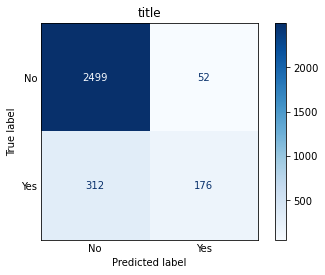

classifier name RandomForest Classifier
0.9193813754524515
[[2513   38]
 [ 207  281]]


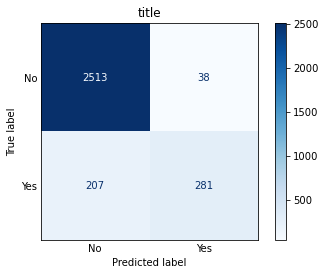

classifier name KNeighbors Classifier
0.8562026982560053
[[2481   70]
 [ 367  121]]


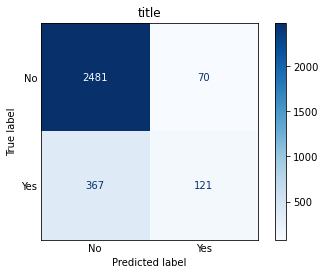

classifier name DecisionTree Classifier
0.907864429088516
[[2413  138]
 [ 142  346]]


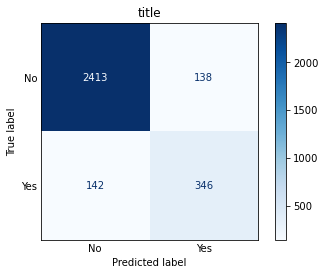

classifier name XGBClassifier
0.9361632115827575
[[2487   64]
 [ 130  358]]


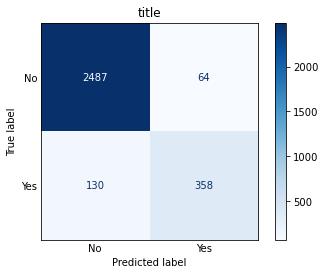

In [20]:
#Model predition
model_names = [
        'Logistic Regression',
        'RandomForest Classifier',
        #'Support Vector Machine',
        'KNeighbors Classifier',
        'DecisionTree Classifier',
        'XGBClassifier'
]

for classifier,classifier_name in zip(models,model_names):
    prediction=classifier.predict(X_test)
    print('classifier name ' + classifier_name)
    print(accuracy_score(y_test,prediction))
    print(confusion_matrix(y_test,prediction))
    make_confusion_matrix(y_test,prediction,"title")

Best Model is from XG Classifier with Score 93%

### Hyperparameter Tuning and Model Training <a id=Hyperparameter_Tuning_Training ></a>

Each model is subject to various hyperparameters that need to be determined. Here random search and grid search methods are used optimise the hyperparameters for our chosen models. 
Grid search exhaustively checks every combinations of hyperparameters given in the parameter domain to optimise the given score, "roc_auc" in this project. 
Random search checks random combinations of hyperparameters for a given number of iterations to optimise the given score. The advantage of random search is shorter time but the trade-off is that it might miss the best possible combination.

Below are the two functions, rand_search(), and grid_search(), to help in implementation. No scaling is done as it is each feature is already scaled, so then train the models with training dataset.

In [21]:
# rand search function
def rand_search(X_train,y_train,parameters,model,n_iter=100):
    scoring = 'roc_auc'
    verbose = 1
    clf_pipeline = Pipeline([("clf",model)])   
    clf_rand = RandomizedSearchCV(clf_pipeline, parameters, n_iter = n_iter,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1)
    clf_rand.fit(X_train,y_train)  #learn the training set
    
    print("Best parameters for ", model) 
    print(clf_rand.best_params_)
    print(f"\nBest train %s score: {clf_rand.best_score_ :.2f}" % (scoring))
    return clf_rand.best_estimator_

In [22]:
# grid search function
def grid_search(X_train,y_train,parameters,model):
    scoring = 'roc_auc'
    verbose = 1
    clf_pipeline = Pipeline([("clf",model)])   #Pipeline applies scaling and model estimator
    clf_grid = GridSearchCV(clf_pipeline, parameters,  scoring=scoring,verbose = verbose)
    clf_grid.fit(X_train,y_train) 

    print("Best parameters for ", model) 
    print(clf_grid.best_params_)
    print(f"\nBest train %s score: {clf_grid.best_score_ :.2f}" % (scoring))
    return clf_grid.best_estimator_

### Logistic Regression <a id=Logistic_Regression ></a>

This is the basic regression classification

In this package, there are several hyperparameters that we need to pay attention to:

      C: controls the strength of regularisation penalty
      solver: algorithms used for optimisation
      class_weight: weights associated with classes

In [23]:
#Setting ranges for each hyperparameter.
log_params = {"clf__solver": ["lbfgs", "sag", "saga"],
               "clf__C": np.arange(0.1,2,0.1), 
               "clf__class_weight": ["balanced", None]
              }

In [24]:
classifier = LogisticRegression()
log_best_estimator = grid_search(X_train,y_train, log_params,classifier)

Fitting 5 folds for each of 114 candidates, totalling 570 fits
Best parameters for  LogisticRegression()
{'clf__C': 1.9000000000000001, 'clf__class_weight': None, 'clf__solver': 'sag'}

Best train roc_auc score: 0.84


### Random Forest Classification<a id=Random_Forest></a>

Random Forest consists of an ensemble of decision trees. The algorithm splits the dataset into independent random subsamples and selects subsamples of features, and fits a decision tree classfier to each subsample. It then averages the estimates to improve the prediction accuracy.

We will use the class sklearn.ensemble.RandomForestClassifier from scikit learn. Based on our research, there are several hyperparameters that we will need to adjust:

      n_estimator: the number of trees in the forest
      min_samples_split:the minimum number of data points required to be at a leaf node
      max_features: the number of features to consider when looking for the best split
      max_depth: the maximum depth of the tree

In [25]:
#Setting ranges for each parameter.
clf__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
rfc_params = {"clf__n_estimators": np.linspace(start = 100, stop = 1000, num = 10,dtype=int),
              "clf__min_samples_split": np.arange(2,6), 
              "clf__max_features":["sqrt", "log2"],
              "clf__max_depth": clf__max_depth
             }

In [26]:
classifier=RandomForestClassifier(random_state=1,n_jobs=-1)
#classifier__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
#classifier__max_depth.append(None)

rfc_best_estimator = rand_search(X_train,y_train, rfc_params, classifier,n_iter=120) #apply random search

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  RandomForestClassifier(n_jobs=-1, random_state=1)
{'clf__n_estimators': 600, 'clf__min_samples_split': 3, 'clf__max_features': 'sqrt', 'clf__max_depth': 50}

Best train roc_auc score: 0.95


### KNeighbours Classification <a id = KNN><a>

KNeighbours classfication chooses K nearest data points to the unlabeled data point then ask the K neighbours to "vote" for the classes that the point belongs to.

We will use the class sklearn.neighbors.KNeighborsClassifier for the implementation. Important hyperparameters that we will adjust are shown as follows:

      n_neighbors: the number of closest neigbours
      weights: weight function in prediction
      p: Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2




In [27]:
#Setting ranges for the hyperparameters are shown below.
knn_params = {"clf__n_neighbors":[2,5,10,87,100],
              "clf__weights":["uniform", "distance"],
              "clf__p":[1,2] 
             }

In [28]:
classifier = KNeighborsClassifier(n_jobs=-1)
knn_best_estimator = grid_search(X_train,y_train, knn_params, classifier)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for  KNeighborsClassifier(n_jobs=-1)
{'clf__n_neighbors': 87, 'clf__p': 1, 'clf__weights': 'distance'}

Best train roc_auc score: 0.88


###  XGBoost Classification <a id = XGB> </a>

XGBoost uses gradient boosting technique, and is on the priciples of decison tree ensemble, which a set of classification and regression trees. It is similar to Random Forest difference is how the algorithms train the models.

The hyperparameters we need to fine-tune are as follows:

      learning_rate: the learning rate of gradient boosting
      max_depth:maximum tree depth
      min_child_weight: minimum sum of instance weight(hessian) needed in a child. Useful to reduce overfitting
      reg_lambda: L2 regularisation


In [29]:
#Settingranges for the hyperparameter are shown below.
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }

In [30]:
from xgboost import XGBClassifier
classifier = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

xgb_best_estimator = rand_search(X_train,y_train, xgb_params,classifier,n_iter=120)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None, verbosity=0)
{'clf__reg_lambda': 0.2, 'clf__min_child_weight': 1, 'clf__max_depth': 4, 'clf__learning_rate': 0.2}

Best train roc_auc score: 0.97


## Evaluation <a id = "Evaluation"></a>

Now run the model using the best estimators on the test set, and print out the confusion matrix and evaluation metrics.

In [31]:
# Evaluation outputs
evaluation = pd.DataFrame({'Model': [],
                           'Accuracy':[],
                          'Recall':[],
                          'Precision':[],
                          'F1':[],
                          'ROC_AUC':[]})

In [32]:
def evaluate_model(estimator, X_test, y_test, name):
    y_pred = estimator.predict(X_test)
    y_confusion = confusion_matrix(y_test, y_pred)
    y_class_report = classification_report(y_test, y_pred, target_names=["not 1", "1"])
    accuracy = (accuracy_score(y_test, y_pred)*100)
    recall = recall_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    
    if name != 'LogReg':
        y_proba = estimator.predict_proba(X_test)
        fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1])
    else:
        y_proba = estimator.decision_function(X_test)
        fpr, tpr,threshold = roc_curve(y_test, y_proba)
        
    y_auc = auc(fpr, tpr)*100
                                                                                                                                                                                                                                             
    r = evaluation.shape[0]
    evaluation.loc[r] = [name, accuracy, recall, precision, f1, y_auc]  

    print(name, "ROC_AUC Score: %.2f" % y_auc)
    print(name, "confusion matrix\n", y_confusion )
    print(name, "classification report\n", y_class_report )

### Logistic Regression <a id=LogiEval></a>

In [33]:
evaluate_model(log_best_estimator,X_test,y_test, 'Logistic Regression')

Logistic Regression ROC_AUC Score: 83.73
Logistic Regression confusion matrix
 [[2492   59]
 [ 311  177]]
Logistic Regression classification report
               precision    recall  f1-score   support

       not 1       0.89      0.98      0.93      2551
           1       0.75      0.36      0.49       488

    accuracy                           0.88      3039
   macro avg       0.82      0.67      0.71      3039
weighted avg       0.87      0.88      0.86      3039



### Feature Importance <a id=LogiregFImp></a>

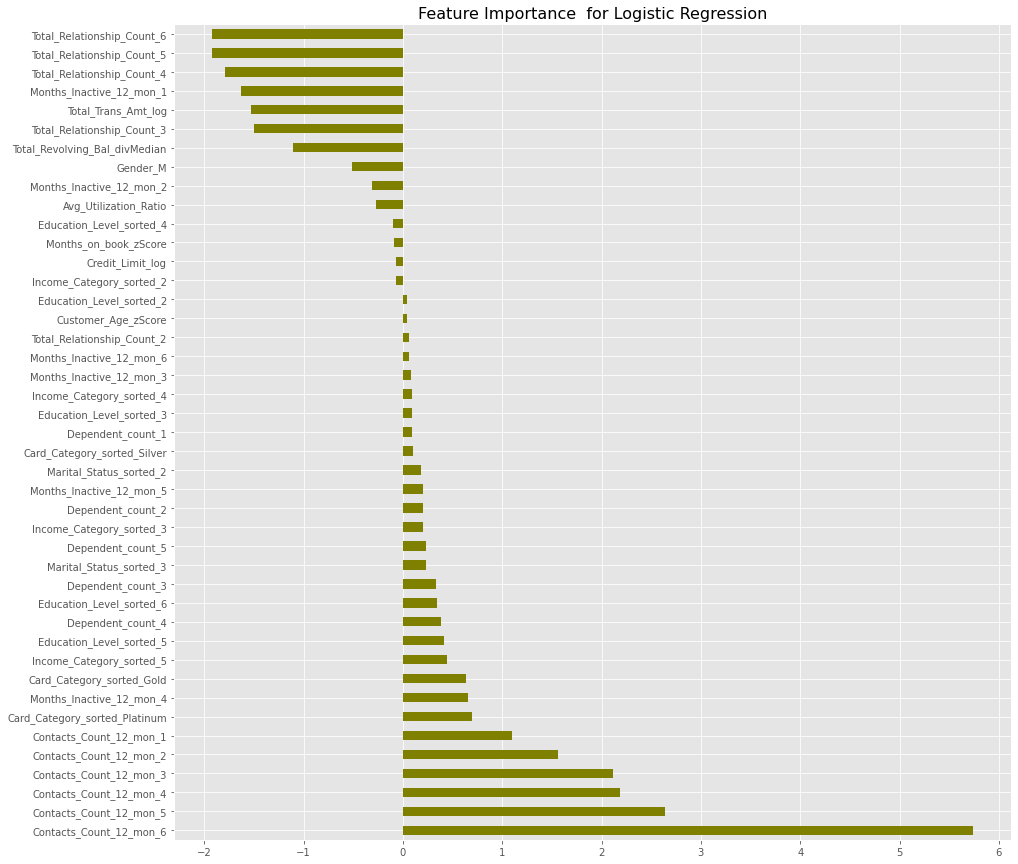

In [34]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
plt.title('Feature Importance  for Logistic Regression', fontsize=16)
feat_importances = pd.Series(log_best_estimator.named_steps["clf"].coef_.tolist()[0], index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize=10,color="olive")
plt.show()

### Random Forest Classification <a id = RFEVAL></a>

In [35]:
evaluate_model(rfc_best_estimator,X_test,y_test, 'RandomForest Classifier')

RandomForest Classifier ROC_AUC Score: 94.83
RandomForest Classifier confusion matrix
 [[2513   38]
 [ 202  286]]
RandomForest Classifier classification report
               precision    recall  f1-score   support

       not 1       0.93      0.99      0.95      2551
           1       0.88      0.59      0.70       488

    accuracy                           0.92      3039
   macro avg       0.90      0.79      0.83      3039
weighted avg       0.92      0.92      0.91      3039



### Feature Importance<a id = RFFImp></a>

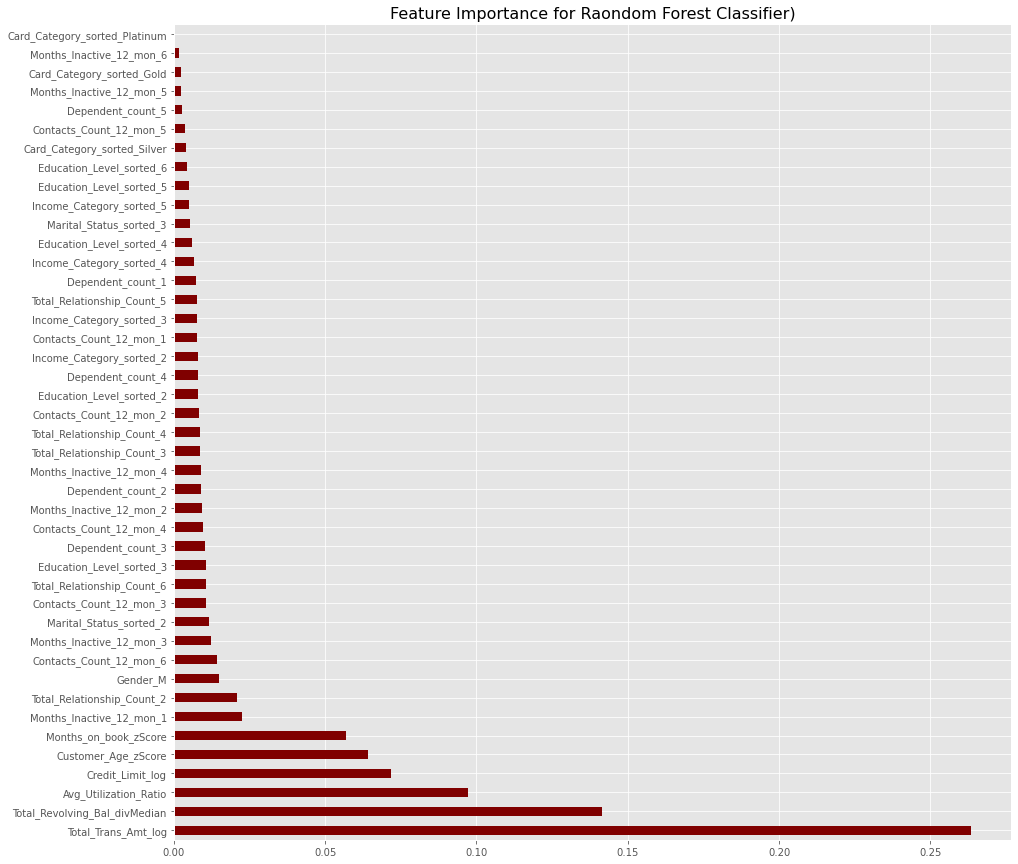

In [36]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
plt.title('Feature Importance for Raondom Forest Classifier)', fontsize=16)
feat_importances = pd.Series(rfc_best_estimator.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize = 10,color ='maroon')
plt.show()

### KNeighbours Classification <a id=KNNEval> </a>

In [37]:
evaluate_model(knn_best_estimator,X_test,y_test, 'KNeigbours Classifier')

KNeigbours Classifier ROC_AUC Score: 86.26
KNeigbours Classifier confusion matrix
 [[2551    0]
 [ 441   47]]
KNeigbours Classifier classification report
               precision    recall  f1-score   support

       not 1       0.85      1.00      0.92      2551
           1       1.00      0.10      0.18       488

    accuracy                           0.85      3039
   macro avg       0.93      0.55      0.55      3039
weighted avg       0.88      0.85      0.80      3039



### Feature Importance <a id = KNNFImp></a>

KNN does not have "feature_importances_" object

### XGBoost Classification <a id =XGBEval></a>

In [38]:
evaluate_model(xgb_best_estimator,X_test,y_test, 'XGBoost Classifier')

XGBoost Classifier ROC_AUC Score: 96.94
XGBoost Classifier confusion matrix
 [[2488   63]
 [ 128  360]]
XGBoost Classifier classification report
               precision    recall  f1-score   support

       not 1       0.95      0.98      0.96      2551
           1       0.85      0.74      0.79       488

    accuracy                           0.94      3039
   macro avg       0.90      0.86      0.88      3039
weighted avg       0.94      0.94      0.94      3039



### Feature Importance <a id = FeaImp></a>

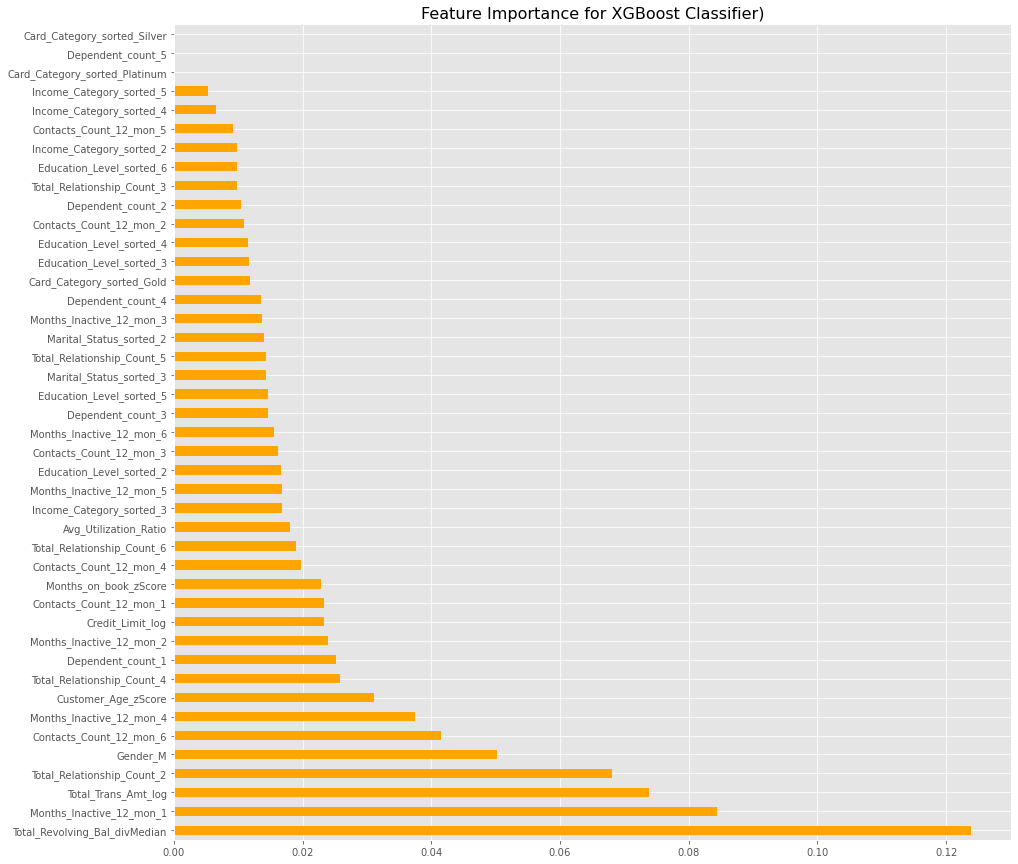

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
plt.title('Feature Importance for XGBoost Classifier)', fontsize=16)
feat_importances = pd.Series(xgb_best_estimator.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize=10,color='orange')
plt.show()

In [40]:
evaluation.sort_values(by ='ROC_AUC', ascending = False)

,Model,Accuracy,Recall,Precision,F1,ROC_AUC
3,XGBoost Classifier,93.715038,73.770492,85.106383,79.034029,96.940287
1,RandomForest Classifier,92.102665,58.606557,88.271605,70.443350,94.833832
2,KNeigbours Classifier,85.488648,9.631148,100.000000,17.570093,86.255149
0,Logistic Regression,87.824942,36.270492,75.000000,48.895028,83.732673


### ROC Curve <a id=ROCCurve></a>

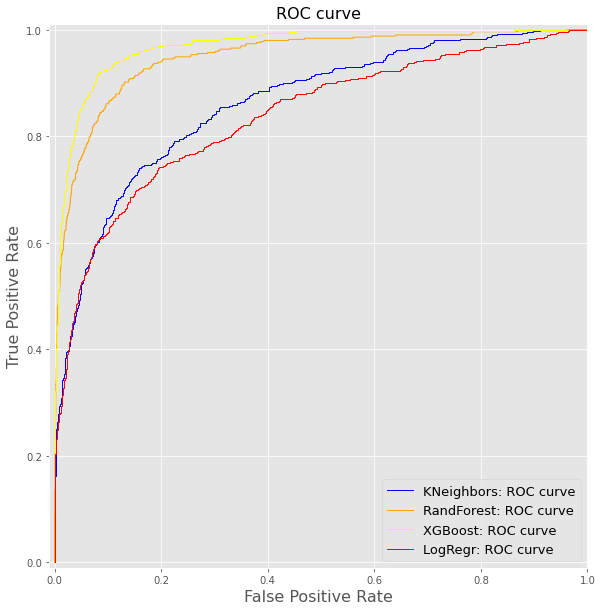

In [41]:
y_proba_knn = knn_best_estimator.predict_proba(X_test)
y_proba_rfc = rfc_best_estimator.predict_proba(X_test)
y_proba_xgb = xgb_best_estimator.predict_proba(X_test)
y_scores_log = log_best_estimator.decision_function(X_test)

fpr_knn, tpr_knn, knn_thresholds = roc_curve(y_test, y_proba_knn[:,1])
fpr_rfc, tpr_rfc, rfc_thresholds = roc_curve(y_test, y_proba_rfc[:,1])
fpr_xgb, tpr_xgb, xgb_thresholds = roc_curve(y_test, y_proba_xgb[:,1])
fpr_log, tpr_log, log_thresholds = roc_curve(y_test, y_scores_log)

plt.figure(figsize=(10,10))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNeighbors: ROC curve', color='blue')
plt.plot(fpr_rfc, tpr_rfc, lw=1, label='RandForest: ROC curve', color='orange')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost: ROC curve', color='yellow')
plt.plot(fpr_log, tpr_log, lw=1, label='LogRegr: ROC curve', color='red')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.axes().set_aspect('equal')
plt.show();

## Additional Models: <a id=AdditionalModels></a>

We have selected four of the many machine learning models available. It would be interesting to see the results of other models.
Feature importance: With the knowledge of the feature importance, we can run the model on a dataset containing only the important features and compare the results.
    
Along with neural networks, other popular prediction techniques can be applied in combination, such as support vector machine develop hybrid  model

## Summary <a id =Summary> </a>

XGbooost performed best with grid search along with Random Forest among teh four models interms of ROC_AUC

The top 3 most important feature from XGBoost model are (in descending order):

    Total_Trans_Ct (Total transaction count in the last 12 months)
    Total_Revolving_Bal (Total revolving balance on the credit card)
    Total_Relationship_Count (Total number of products held by the customer)

The top 3 most important feature from Random forest model are (in descending order):

    Total_Trans_Amt (Total transaction amount in the last 12 months)
    Total_Trans_Ct (Total transaction count in the last 12 months)
    Total_Ct_Chng_Q4_Q1 (Change in Transaction Count from Q4 to Q1)
It can be concluded Total_Trans_Ct is the most important common predictor of churners based on these findings.


## Recommendations <a id = Recom></a>

Lower transcation count on credit card , less revolving balance , less transcational amount are an indication that customer will attrite.
Lower transcation indicate customer is not using this credit card , Bank may need to consider Cash back, or rewards or some other offers to customer to use the credit card more.

  From the EDA 
* Customers who have had high number of contacts with the bank in the last 12 months have attrited. This needs to be investigated whether there were any issues of customers that were not resolved made customer leaving the bank.
* The proportion of income category of attrited customer, it is highly concentrated around 60K - 80K income, followed by Less than 40K income  compare to attrited customers with higher annual income of 80K-120K and over 120K+.
* Customers who are inactive for a month show high chances of attrition.Bank should focus on these customers as well.
* Customer in age range 36-55 ,who were doctorate or postgraduate  and/or Female attrited more.Reasons need to be further investigated.
* customer having more product with the bank he/she is less likely to attrite.This may be indication for Bank to offer different service to customer.
* Avg utilization ratio is lower amongst attrited customers.